# KYB and Profiling

Companies may not always be trusted in their reports. Intentionally falsified reports can be related to:

- fraudulent misreporting, e.g. motivated by deceiving investors
- sanction evasion, e.g., illegal sale of dual-use goods
- e-commerce fraud, e.g., posing as an online store using artificially generated fake business date
- firms involved in money laundering, e.g., reporting fictitious turnover

To combat such fraud, KYB (Know Your Business) compliance processes are implemented by stakeholders.

In [207]:
# Load libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy.spatial.distance import mahalanobis
from behaviors import business_profile
from datetime import datetime, timedelta
from scipy.stats import zscore


## Anomalies and Good old p-values

Consider a business selling a product with a price $x$. This price will follow a probability distribution $P(X)$ centered around some average; the average market price, depending on various factors such as location, year season, supply costs, etc. 

For simplicity, let us assume that all these factors are random and the final market price is normally distributed with some mean $\mu$ and variance $\sigma$.

Now imagine you are a customer buying this product online. You browse various websites and see the best deal, that is almost too good to be true. Now, is it?  

> What is the probability that too low price listed on the website means that the website is a scam?

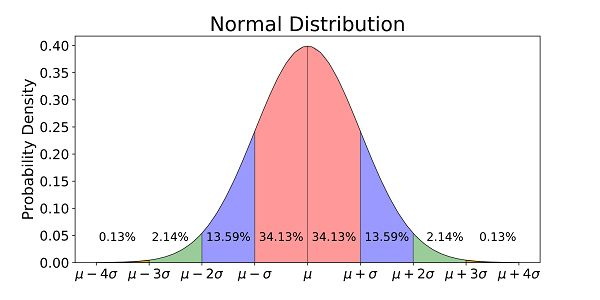

## Checking firm's profile

Consider a firm that you are interested to start business relations. This firm is relatively new and you want to investigate if their reports are plausible with respect to other similar companies.

In this exercise, we generate multiple synthetic reports with one fraudulent one, and demonstrate methods how we can make a comparison.

In [208]:
report_generator = business_profile()
current_date = datetime(2022, 4, 1, 8, 0, 0) 

In [209]:
n_honest_companies = 500
n_months = 12

reports = []
for n in range(n_honest_companies):
    reports = reports + report_generator.generate(current_date, n_months, company_id = n)

reports = pd.DataFrame.from_records(reports)
reports.head(5)

,month,total_units_sold,average_price_per_unit,total_revenue,gross_margin,gross_profit,operating_expenses,net_profit,company_id
0,2022-04-01 08:00:00,189084,6.90,1303975.00,0.2987,389445.32,301897.46,87547.86,0
1,2022-05-01 08:00:00,205327,6.35,1304137.31,0.3300,430424.23,309643.90,120780.33,0
2,2022-06-01 08:00:00,211707,6.05,1281115.23,0.2681,343509.87,281056.57,62453.29,0
3,2022-07-01 08:00:00,209626,6.32,1324066.31,0.2673,353979.39,313981.75,39997.64,0
4,2022-08-01 08:00:00,165416,6.83,1129359.09,0.3025,341681.51,283288.36,58393.15,0


Generate data that are fake/falsified

In [210]:
reports_client = report_generator.generate(current_date, n_months)
reports_client = pd.DataFrame.from_records(reports_client)
reports_client['total_units_sold'] = reports_client['total_units_sold'] + int(random.gauss(10000, 2000))

### Mahalanobis distance

Mahalanobis distance is a measure of distance between a point and a distribution, or between two points, in multivariate space. Unlike Euclidean distance, it accounts for correlations between variables and differences in their scales, making it especially useful when variables are correlated or have different units

Mahalanobis distance from a point  $X$ to a mean vector $\mu$:

$$
D_M(X, \mu) = \sqrt{(X - \mu)^T \Sigma^{-1} (X - \mu)}
$$

Mahalanobis distance between two points  $X_A$ and $X_B$:

$$
D_M(X_A, X_B) = \sqrt{(X_A - X_B)^T \Sigma^{-1} (X_A - X_B)}
$$



In [211]:
# Compute mean vector and covariance matrix from the sample data --- assumes multivariate normality
reports_train_data = reports.drop(columns=["month", "company_id"])
mean_vector = reports_train_data.mean()
cov_matrix = reports_train_data.cov()
cov_inv = np.linalg.inv(cov_matrix)

In [212]:
client_data = reports_client.drop(columns=["month"])

# Calculate Mahalanobis distance for each report
distances_client = []
for index, row in client_data.iterrows():
    distances_client.append(mahalanobis(row.to_numpy(), mean_vector.values, cov_inv))

In [213]:
n_test_companies = 50

testing_data = []
for n in range(n_honest_companies, n_honest_companies + n_test_companies):
    testing_data = testing_data + report_generator.generate(current_date, n_months, company_id = n)

testing_data = pd.DataFrame.from_records(testing_data)

numeric_df_test = testing_data.drop(columns=["month", "company_id"])
# Calculate Mahalanobis distance for each report
distances_testing_data = []
for index, row in numeric_df_test.iterrows():
    distances_testing_data.append(mahalanobis(row.to_numpy(), mean_vector.values, cov_inv))

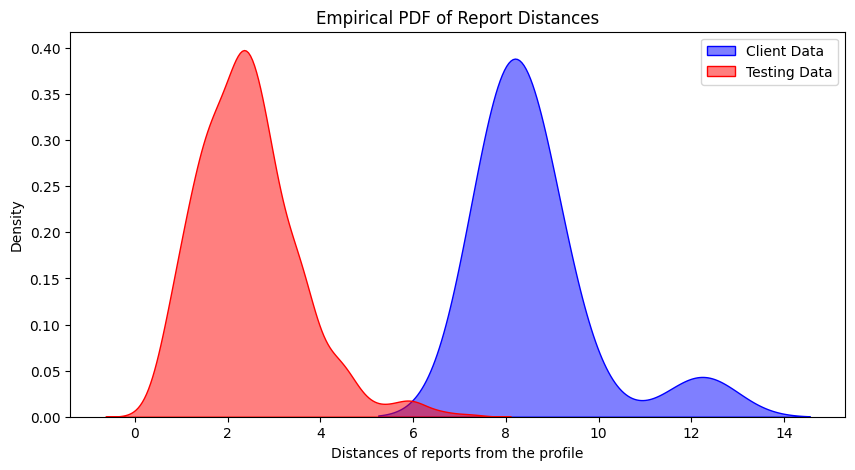

In [214]:
fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(distances_client, label='Client Data', color='blue', fill=True, alpha=0.5)
sns.kdeplot(distances_testing_data, label='Testing Data', color='red', fill=True, alpha=0.5)

ax.set_xlabel('Distances of reports from the profile')
ax.set_ylabel('Density')
ax.set_title('Empirical PDF of Report Distances')
ax.legend()

plt.show()

#### Discussion

* Does this remind you of p-values?
* What regions in the plot of two empirical probability density distributions corresponds to errors? 

## Money laundering via fictitious company turnover

Now, let us consider the case that you already have data on one particular (or multiple) criminal activities. This can be modelled as a supervised learning problem


### Context

In this example, we will look at a specific real-world case of money laundering:

> A person involved in cannabis cultivation started a taxi company with 12 taxis with the aim of laundering the criminal proceeds. Private loans and turnover were falsified via the company. The stated turnover did not correspond with the data recorded by the taximeters.

source: [Dutch National Risk Assessment on Money
Laundering 2019](https://repository.wodc.nl/bitstream/handle/20.500.12832/249/Cahier_2020-11a_Full_text_2689h_tcm28-470222.pdf?sequence=6&isAllowed=y)

In this **specific case** we can utilize *supervised anomaly detection*


### Data

We use real world data of taxi rides: [source](https://www.kaggle.com/datasets/mickhirsh/taxi-data-set/)

In [215]:
df_taxi = pd.read_csv('.\\data\\Taxi_Set.csv')


df_taxi['driver_id'] = random.choices(['mary','joe','sue'], k=df_taxi.shape[0])
df_taxi['true_label'] = 0

#fare_w_flag = 2.70 + wait_time_cost + distance_cost
#total_fare_new = miscellaneous_fees + tip + fare_w_flag
#surge applied taxi = increasing the price with higher demand
print(df_taxi.shape)
df_taxi.head(10)

(207596, 15)


,trip_duration_sec,trip_duration_min,trip_duration_hr,distance_traveled_Km,KPH,wait_time_cost,distance_cost,fare_w_flag,tip,miscellaneous_fees,total_fare_new,num_of_passengers,surge_applied,driver_id,true_label
0,748,12.47,0.207833,2.75,13.231756,4.97,4.27,11.94,24,6.30,42.24,1,False,mary,0
1,1187,19.78,0.329667,3.43,10.404449,7.89,5.33,15.92,24,13.20,53.12,1,False,sue,0
2,730,12.17,0.202833,3.12,15.382087,4.85,4.85,12.40,0,26.63,39.03,1,True,mary,0
3,671,11.18,0.186333,5.63,30.214669,4.46,8.75,15.91,0,9.75,25.66,3,False,mary,0
4,329,5.48,0.091300,2.09,22.883212,2.19,3.25,8.14,12,13.20,33.34,1,False,joe,0
5,355,5.92,0.098700,1.74,17.635135,2.36,2.70,7.76,0,26.63,34.39,1,True,mary,0
6,453,7.55,0.125833,2.22,17.642384,3.01,3.45,9.16,0,6.00,15.16,1,False,sue,0
7,1288,21.47,0.357833,5.21,14.559851,8.56,8.09,19.35,36,26.33,81.68,1,True,joe,0
8,134,2.23,0.037200,1.48,39.820628,0.89,2.30,5.89,0,6.00,11.89,1,False,joe,0
9,980,16.33,0.272167,3.48,12.786283,6.52,5.41,14.63,0,6.00,20.63,1,False,sue,0


array([[<Axes: title={'center': 'trip_duration_sec'}>,
        <Axes: title={'center': 'distance_traveled_Km'}>,
        <Axes: title={'center': 'tip'}>],
       [<Axes: title={'center': 'fare_w_flag'}>,
        <Axes: title={'center': 'miscellaneous_fees'}>,
        <Axes: title={'center': 'total_fare_new'}>]], dtype=object)

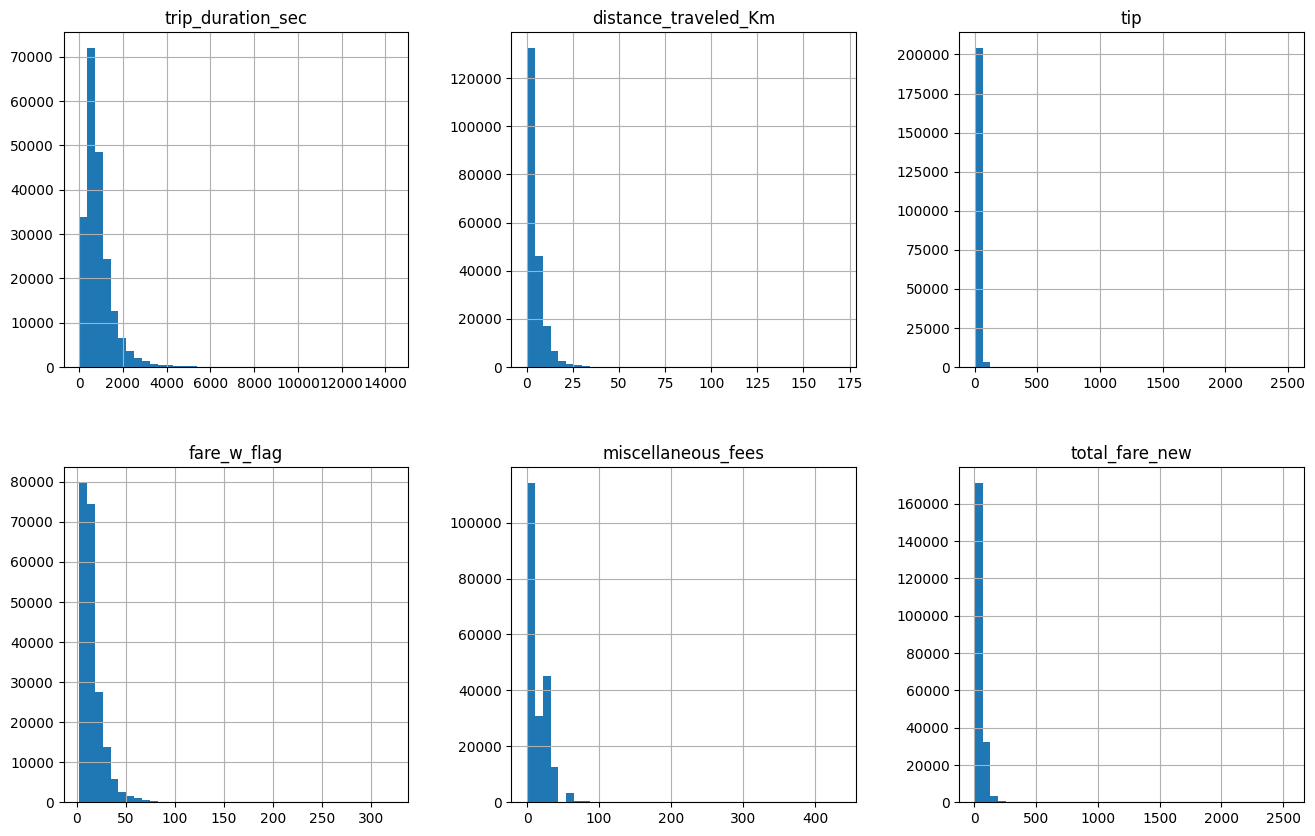

In [216]:
df_taxi.hist(['trip_duration_sec', 'distance_traveled_Km', 'tip', 'fare_w_flag','miscellaneous_fees','total_fare_new'], bins = 40, figsize = (16,10), layout = (2,3))

#### generate misreported data

In [254]:
#let us generate behavior of a money laundering driver
# Shady Bob is reporting false data!

def money_laundering_driver(df_taxi, nr_rides = 50000):
    #shady bob samples honest reports
    df = df_taxi.sample(n=nr_rides, replace = True, random_state=2025)
    df['driver_id'] = ['shady bob'] * df.shape[0]
    df['true_label'] = 1
    #adds some small amount of money that he wants to legalize, which will be some percentage of the real fee
    fictious_fee_percent = random.uniform(0.15,0.2)
    #Shady Bob is not very smart, so he will add it to the distance cost (not knowing that's something we can compare with km)
    df['distance_cost'] = df['distance_cost'] * (1 + fictious_fee_percent)
    #bob recalculates the new price
    df['fare_w_flag'] = 2.70 + df['wait_time_cost'] + df['distance_cost']
    df['total_fare_new'] = df['miscellaneous_fees'] + df['tip'] + df['fare_w_flag']

    return df


df_fraudulent = money_laundering_driver(df_taxi)

### Supervised detection using decision trees






In [255]:
df = pd.concat([df_taxi, df_fraudulent])
y = df['true_label'].to_list()

#we drop columns that wont be used for clustering
del df['trip_duration_min']
del df['trip_duration_hr']
del df['KPH']
del df['num_of_passengers']
del df['driver_id']
del df['true_label']

#we map bool column to int
df['surge_applied'] = df['surge_applied'].astype(int)

#we perform z-score transformation on each column except the surge_applied column
#for column in df.columns.drop('surge_applied'):
#    df[column] = (df[column] - df[column].mean()) / df[column].std()

# view normalized data
df.head(5)

,trip_duration_sec,distance_traveled_Km,wait_time_cost,distance_cost,fare_w_flag,tip,miscellaneous_fees,total_fare_new,surge_applied
0,748,2.75,4.97,4.27,11.94,24,6.30,42.24,0
1,1187,3.43,7.89,5.33,15.92,24,13.20,53.12,0
2,730,3.12,4.85,4.85,12.40,0,26.63,39.03,1
3,671,5.63,4.46,8.75,15.91,0,9.75,25.66,0
4,329,2.09,2.19,3.25,8.14,12,13.20,33.34,0


In [256]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [257]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [258]:
# Create Decision Tree classifier object
clf = DecisionTreeClassifier(max_depth = 5, max_leaf_nodes=20)

# Train Decision Tree Classifier
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [259]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8709481230347184


In [260]:
print("f1_score:",metrics.f1_score(y_test, y_pred))

f1_score: 0.4991210888453619


In [261]:
print("matthews correlation coefficient:", metrics.matthews_corrcoef(y_test, y_pred))

matthews correlation coefficient: 0.5354314788735337


### Interpretability of results

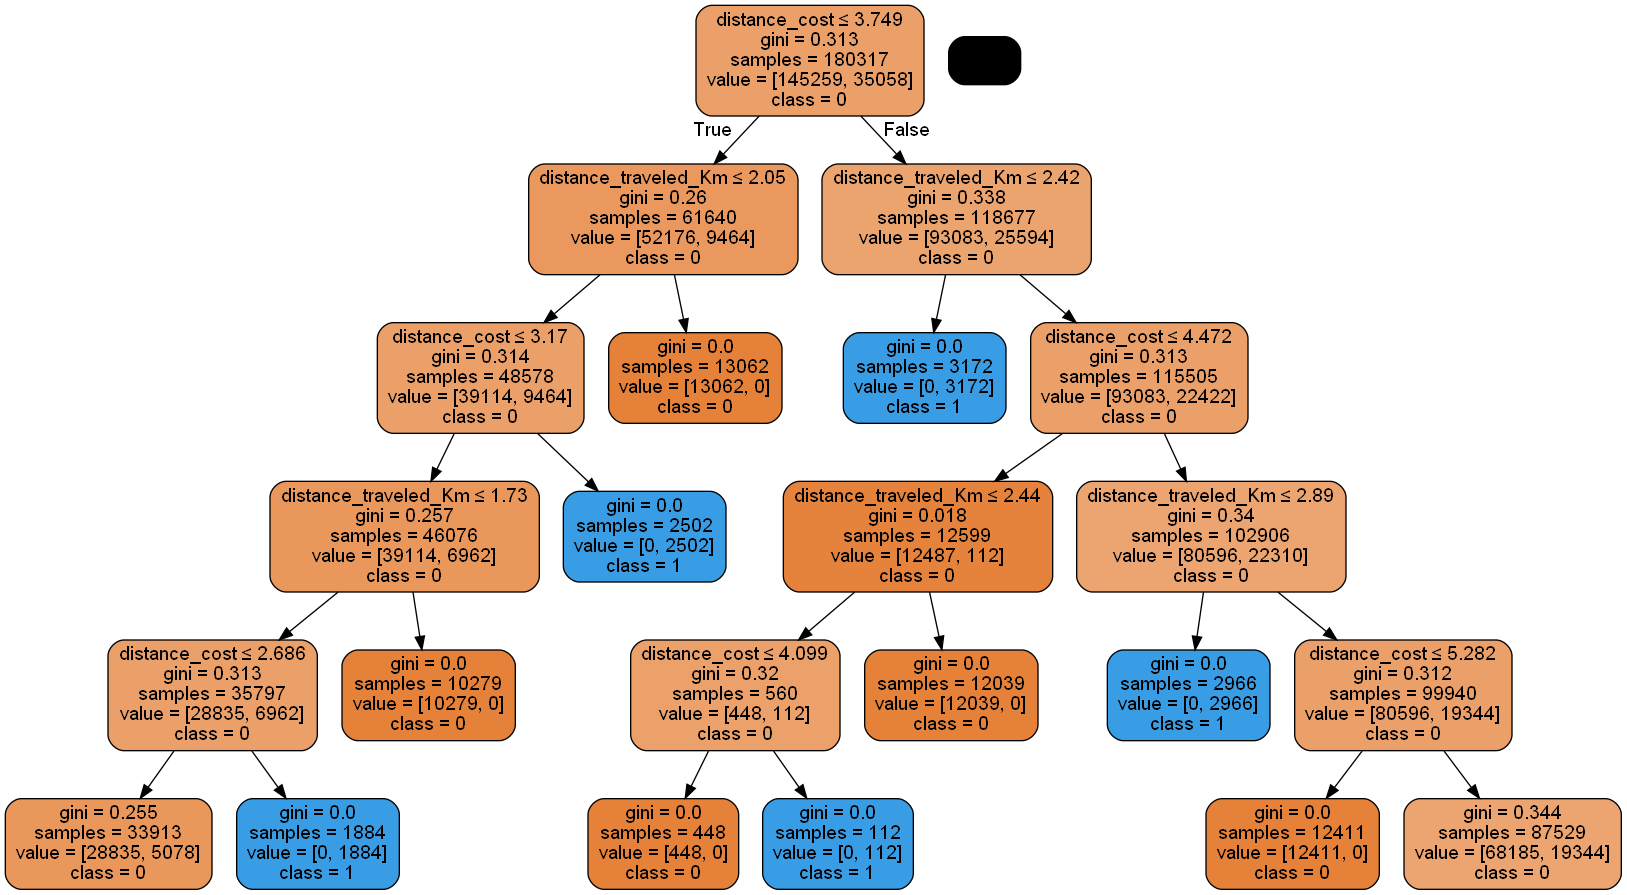

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = df.columns.to_list(), class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('decision tree.png')
Image(graph.create_png())

#### Utility of noncomplinace

*  Each non-compliance is done because it generates profits.
*  Thereofre, we do not need to catch every criminal. We only need to catch the ones that make the most money, and eridicate non-compliance economically by (1) developing advanced technology, and (2) optimizing our resource allocation
